In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import scanpy as sc
from sklearn.metrics import (
    silhouette_score, 
    adjusted_rand_score, 
    normalized_mutual_info_score,
    homogeneity_score,
)
import anndata as AnnData
import scvi
from scvi.model import SCVI
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

sys.path.append(os.path.abspath("../src"))
from model import InformedSCVI
from pathway import get_pathway_masks, get_random_masks, filter_genes
from train import plot_loss

warnings.simplefilter("ignore")
sc.logging.print_header()
sc.settings.figsize = (10, 10)
sc.settings.figdir = "../results/figures/"
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sns.set_theme()
torch.set_float32_matmul_precision("high")

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

c:\Users\mlsar\anaconda3\envs\scvi\Lib\site-packages\docrep\decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
c:\Users\mlsar\anaconda3\envs\scvi\Lib\site-packages\docrep\decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
Seed set to 0


Last run with scvi-tools version: 1.3.0


In [2]:
adata = sc.read("../results/models/piscVI.h5ad")

In [30]:
adata

AnnData object with n_obs × n_vars = 36763 × 1839
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden', '_scvi_batch', '_scvi_labels', 'leiden_piscVI', 'leiden_piscVI_pathways', 'leiden_piscVI_rnd', 'leiden_piscVI_pathways_rnd', 'leiden_piscVI_zinb_lrelu', 'leiden_piscVI_zinb_tanh', 'leiden_piscVI_zinb_sigmoid', 'leiden_piscVI_nb_relu', 'leiden_piscVI_poisson_relu', 'leiden_piscVI_normal_lrelu', 'leiden_piscVI_normal_tanh', 'leiden_piscVI_normal_sigmoid'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell1_colors', 'cell2_colors', 'leiden', 'leiden_colors', 'leiden_piscVI', 'leiden_piscVI_nb_relu', 'leiden_piscVI_normal_lrelu', 'leiden_piscVI_normal_sigmoid', 'leiden_piscVI_normal_tanh', 'leiden_piscVI_pathways', 'leiden_piscVI_pathways_rnd', 'leiden_piscVI_poisson_relu', 'leiden_piscVI_rnd', 'leiden_piscVI_zinb_lrelu', 'leiden_piscVI_zinb_sigmoid', 'leiden_piscVI_zinb_tanh', '

In [26]:
all_keys = [
    "scVI_hvg", "scVI_hvg_funct", #Standard scVI
    "piscVI","piscVI_pathways","piscVI_rnd", "piscVI_pathways_rnd", # Standard piscVI
    "piscVI_zinb_lrelu", "piscVI_zinb_tanh", "piscVI_zinb_sigmoid", # Different activation functions
    "piscVI_nb_relu", "piscVI_poisson_relu", # Different distributions
    "piscVI_normal_lrelu", "piscVI_normal_tanh", "piscVI_normal_sigmoid", # Log1p layer
    "piscVI_kegg", "piscVI_kegg_rnd", "piscVI_kegg_pathways", "piscVI_kegg_pathways_rnd", # kegg pathways
    "piscVI_reactome", "piscVI_reactome_rnd", # Reactome pathways
]
#adata_reactome = adata_reactome.copy()
for key in all_keys:
    if f"X_{key}" not in adata.obsm.keys():
        print(f"Key {key} not in adata")
        continue

In [29]:
adata_hvg = sc.read("../data/NBsmall/NB.bone.Met_preprocessed.h5ad")

Only considering the two last: ['.Met_preprocessed', '.h5ad'].
Only considering the two last: ['.Met_preprocessed', '.h5ad'].


KeyboardInterrupt: 

In [11]:
sc.pp.highly_variable_genes(
    adata_hvg, flavor="seurat_v3", layer="RNA", n_top_genes=2000, subset=True
)

In [12]:
adata_hvg_functional = adata_hvg[:, ~adata_hvg.var['ensembl_gene_id'].isna()]

In [28]:
adata_reactome = sc.read("../data/NBsmall/NB.bone.Met_preprocessed.h5ad")
adata_reactome = adata_reactome[:, ~adata_reactome.var['ensembl_gene_id'].isna()]

genes_per_pathway, genes_per_circuit, circuits_per_pathway = get_pathway_masks("Reactome")
adata_reactome, genes_per_pathway, _, _ = filter_genes(adata_reactome, genes_per_pathway, genes_per_circuit, circuits_per_pathway)
frac = genes_per_pathway.sum(axis=1).mean() / genes_per_pathway.shape[1]
print(f"Fraction: {frac}")

Only considering the two last: ['.Met_preprocessed', '.h5ad'].
Only considering the two last: ['.Met_preprocessed', '.h5ad'].
Current directory: c:\Users\mlsar\Documents\PISCVI\piVAE\notebooks
Fraction: 0.005165700308316872


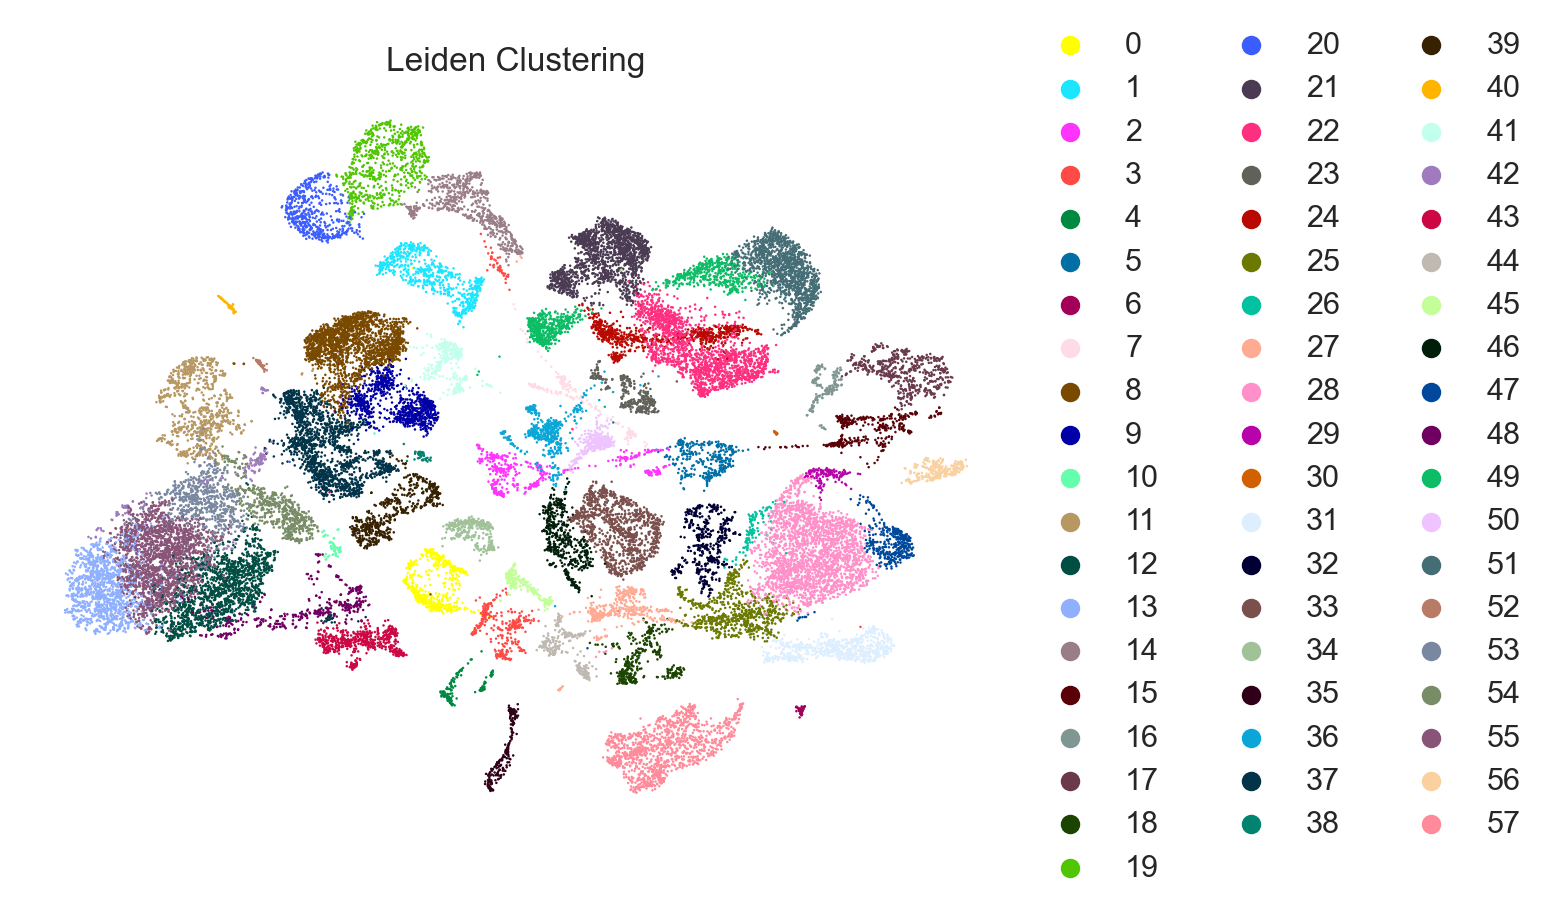

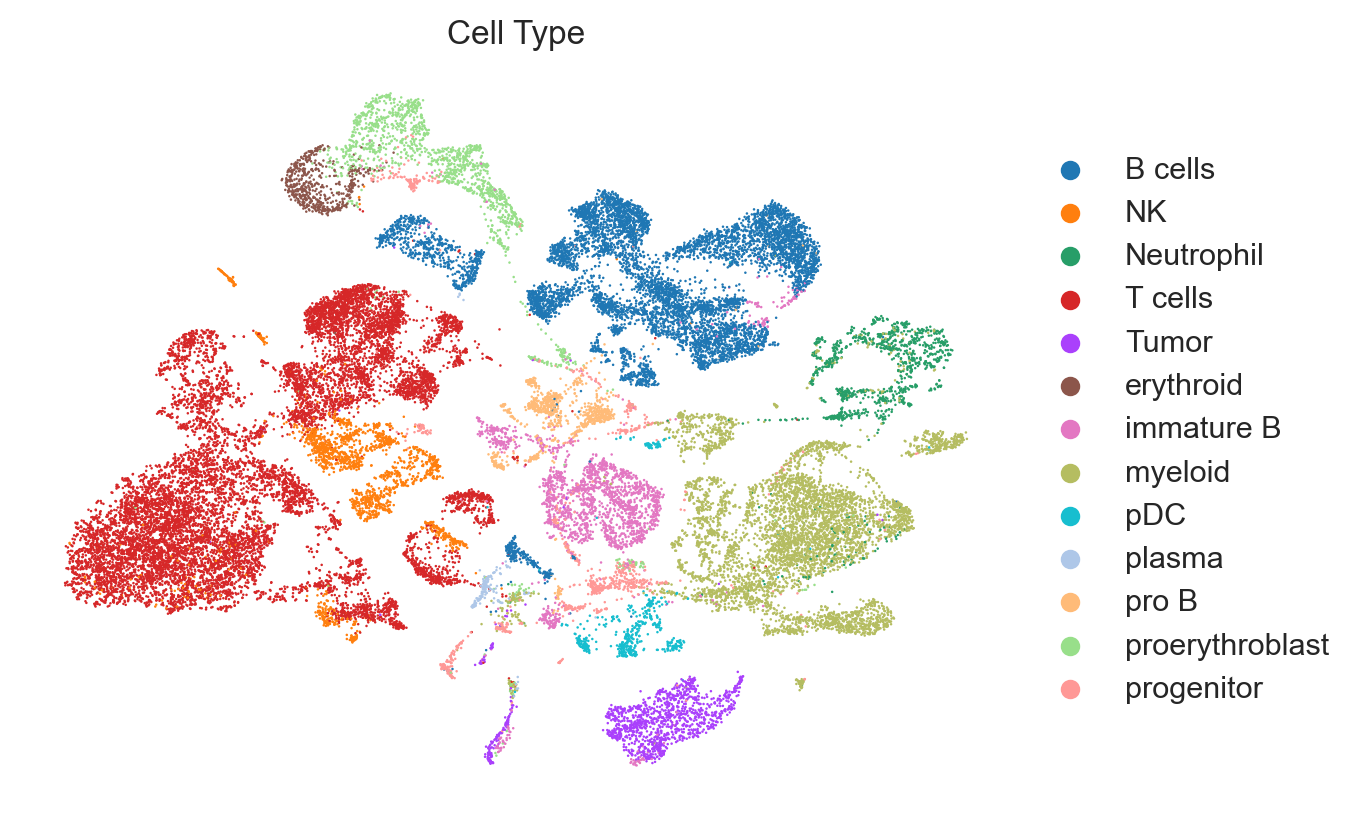

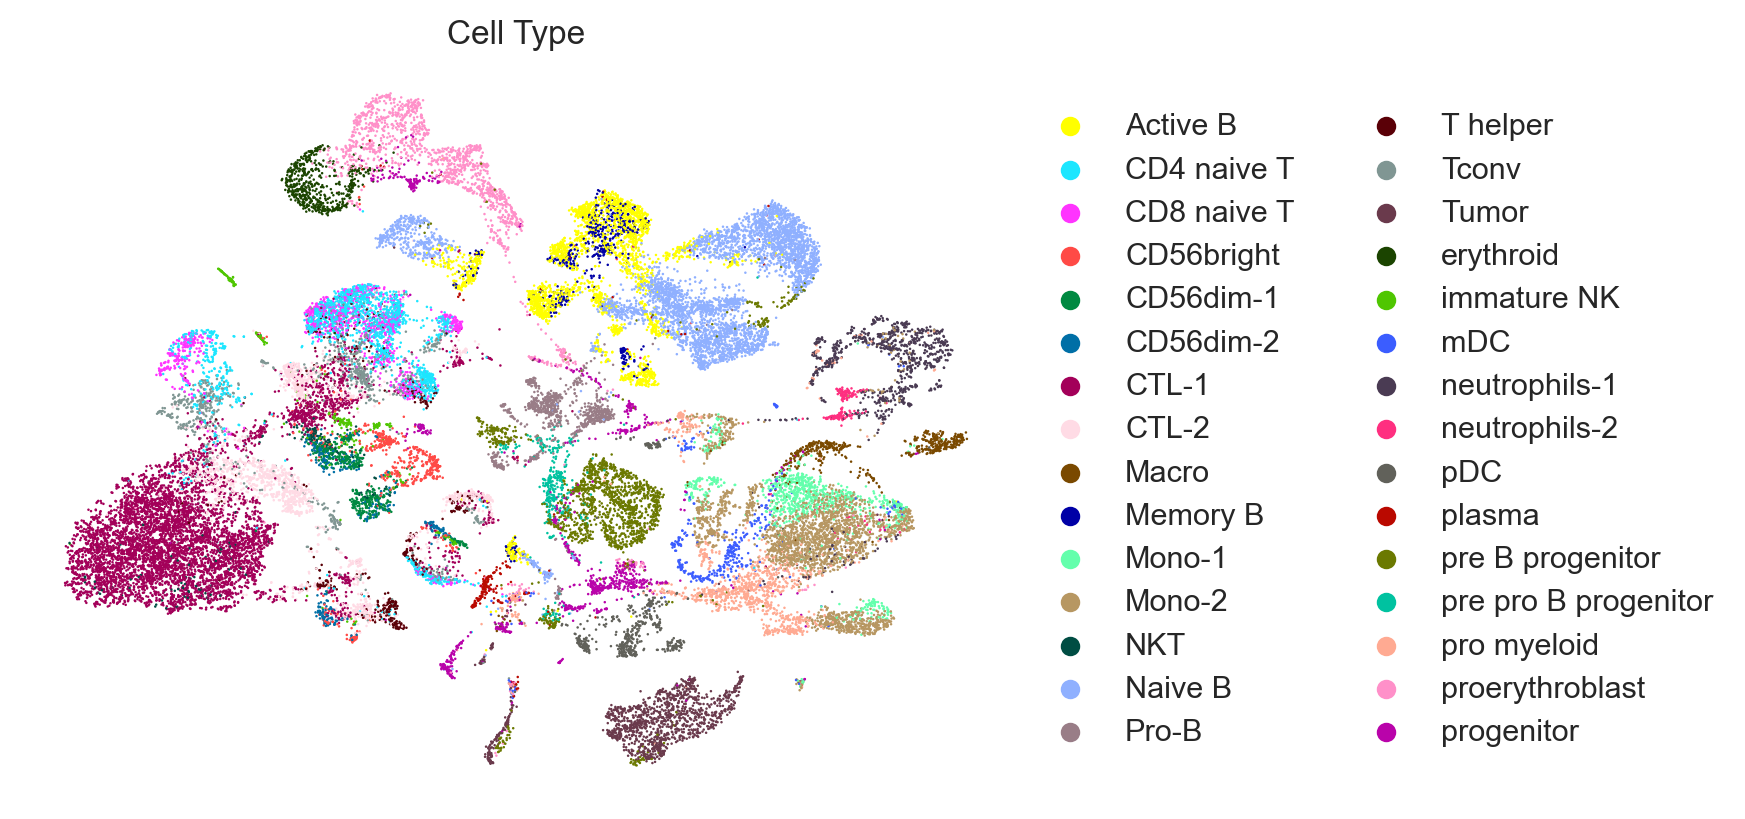

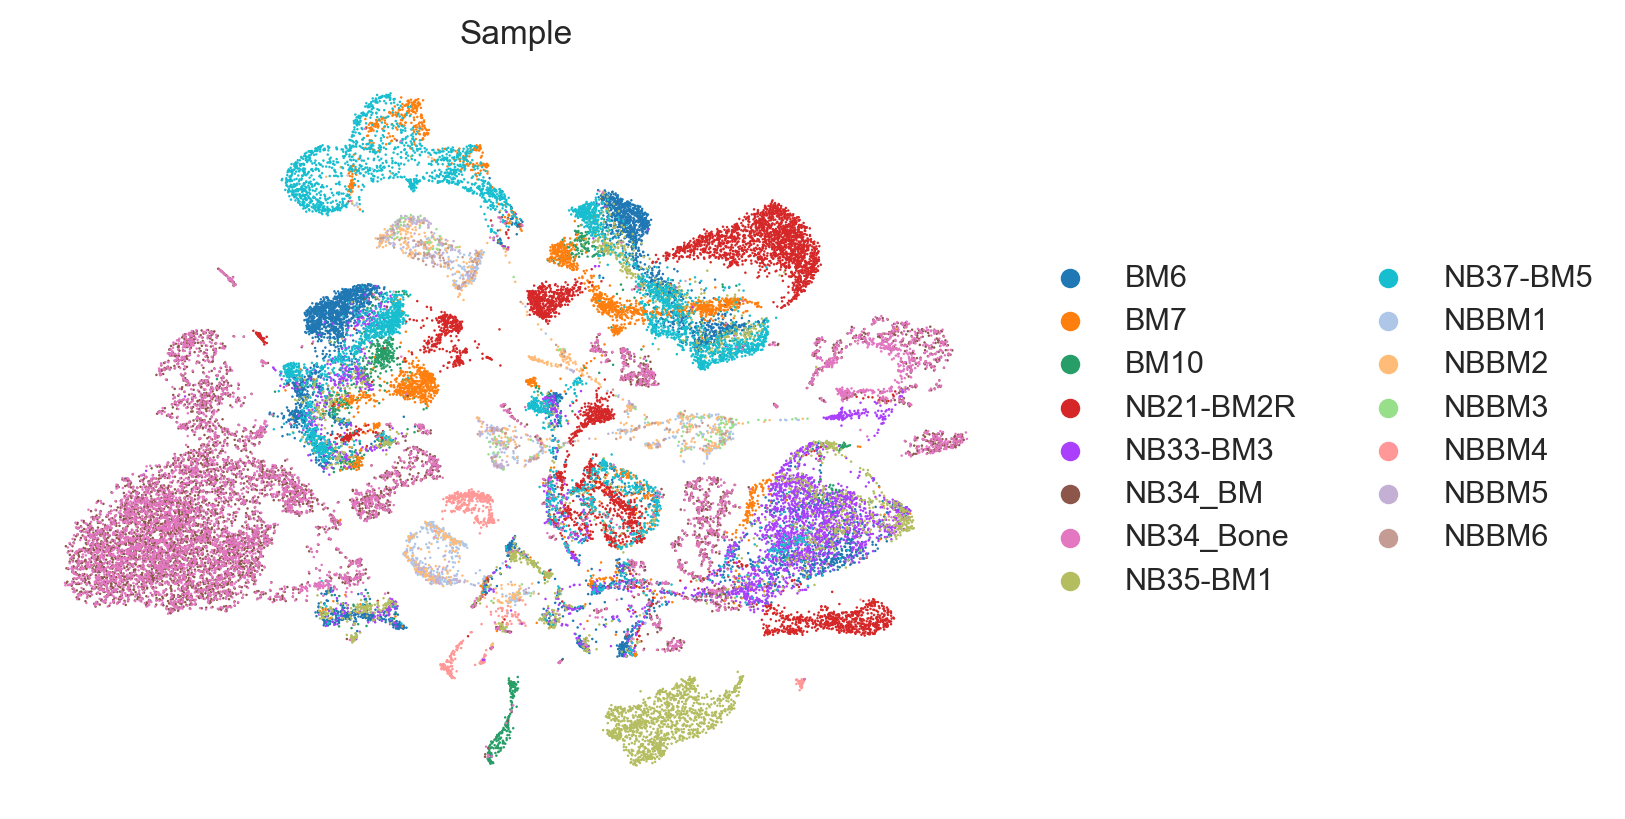

In [4]:
#Plot
sc.pl.umap(
    adata_blank,
    color=["leiden"],
    title="Leiden Clustering",
    frameon=False,
    show=True,
)
sc.pl.umap(
    adata_blank,
    color=["cell1"],
    title="Cell Type",
    frameon=False,
    show=True,
)
sc.pl.umap(
    adata_blank,
    color=["cell2"],
    title="Cell Type",
    frameon=False,
    show=True,
)
sc.pl.umap(
    adata_blank,
    color=["sample"],
    title="Sample",
    frameon=False,
    show=True,
)

In [4]:
adata_blank = adata_blank[:, ~adata_blank.var['ensembl_gene_id'].isna()]
adata_blank

View of AnnData object with n_obs × n_vars = 36763 × 19064
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [5]:
#TODO: test tanh activation function for encoder and decoder
#TODO: test random matrices with all genes (not only functional genes)
#TODO: test random matrices with the same frequency as real ones (and maybe also same variance, other moments)
#TODO: test masking different modules (encoder, decoder, both)
#TODO: test forward and backward circuits

In [5]:
genes_per_pathway, genes_per_circuit, circuits_per_pathway = get_pathway_masks("KEGG")
adata_filtered, genes_per_pathway, genes_per_circuit, circuits_per_pathway = filter_genes(adata_blank, genes_per_pathway, genes_per_circuit, circuits_per_pathway)
n_circuits = genes_per_circuit.shape[0]
print("Number of circuits:", n_circuits)
n_pathways = genes_per_pathway.shape[0]
print("Number of pathways:", n_pathways)
print("Number of genes:", genes_per_pathway.shape[1])
rnd_genes_per_pathway, rnd_genes_per_circuit, rnd_circuits_per_pathway = get_random_masks(adata_blank.var_names, n_circuits, n_pathways)

Current directory: c:\Users\mlsar\Documents\PISCVI\piVAE\notebooks
Pathway genes: ['AKT3', 'TANK', 'FOXO6', 'KIR2DS2', 'CLDN24', 'PLA2G4B', 'BCL2L11', 'SH2B3', 'HCN4', 'FRAT1', 'MEF2B', 'RASA4B', 'CDH5', 'SPDYE2B', 'PARP2', 'PARP3', 'SPDYE18', 'PPP5D1', 'OCLN', 'CASP12', 'MICA', 'KLRC4-KLRK1', 'C8ORF44-SGK3', 'DNM1L', 'NR1H3', 'ARPC5', 'ARPC4', 'ARPC3', 'ARPC1B', 'SPDYE11', 'PPIF', 'ARPC2', 'SGK2', 'RAD50', 'HIPK3', 'RASGRP1', 'ABI2', 'PLXNC1', 'RASA4', 'LPAR6', 'WASF2', 'CDK2', 'CDK4', 'PSME3', 'CDK5', 'CALCRL', 'CDK6', 'CDK7', 'RCAN2', 'RASGRP2', 'KCNMB2', 'GPHN', 'STAM2', 'CDKN1A', 'RAMP2', 'RAMP1', 'RAMP3', 'CDKN1B', 'LOC102723407', 'LOC102723532', 'SPDYE16', 'SPDYE17', 'LOC102725035', 'STAG1', 'CDKN1C', 'TPTEP2-CSNK1E', 'LILRB2', 'CDKN2A', 'APC2', 'PAK4', 'CDKN2B', 'CDKN2C', 'LAMC3', 'CDKN2D', 'RRAGB', 'SIRPB1', 'TLR6', 'IRAG1', 'CCL26', 'KLF2', 'CACNG3', 'CACNG2', 'SEMA3A', 'TUBA1B', 'IRF9', 'MYL12B', 'NOD1', 'ANAPC10', 'MYL9', 'PIAS3', 'RAPGEF3', 'YAP1', 'VAV3', 'TAB1', 'BAIAP2'

In [7]:
frac = genes_per_circuit.sum(axis=1).mean() / genes_per_circuit.shape[1]
print(f"Fraction of genes per circuit: {frac:.2f}")
frac2 = genes_per_pathway.sum(axis=1).mean() / genes_per_pathway.shape[1]
print(f"Fraction of genes per pathway: {frac2:.2f}")
rnd_genes_per_pathway, rnd_genes_per_circuit, rnd_circuits_per_pathway = get_random_masks(adata_blank.var_names, n_circuits, n_pathways, frac=frac)

Fraction of genes per circuit: 0.01
Fraction of genes per pathway: 0.04


In [8]:
masks_kegg_NB = [genes_per_circuit, circuits_per_pathway]
dimensions = [mask.shape for mask in masks_kegg_NB]
dimensions

[(1221, 2540), (93, 1221)]

In [8]:
adata = adata_filtered.copy()

In [12]:
InformedSCVI.setup_anndata(
    adata,
    layer="RNA",
    batch_key="sample",
)

setup_anndata: InformedSCVI


In [13]:
model = InformedSCVI(
    adata,
    dropout_rate= 0.1,
    dispersion = "gene", #["gene", "gene-batch", "gene-label", "gene-cell"]
    gene_likelihood = "zinb", #["zinb", "nb", "poisson", "normal"]
    use_observed_lib_size = True,
    latent_distribution = "normal", #["normal", "ln"]
    activation = "relu", #["relu", "leaky_relu", "tanh", "sigmoid"]
    masks = masks_kegg_NB,
    use_masking = "encoder", #["encoder", "decoder", "both"]
)       

In [14]:
training_plan = model.train(max_epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Initializing MaskedWeights
2 masks found for module encoder.
Mask dimensions for module encoder: [torch.Size([634, 1839]), torch.Size([26, 634])]


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training step 0
Training step 1
Training step 2
Training step 3
Training step 4
Training step 5
Training step 6
Training step 7
Training step 8
Training step 9
Training step 10
Training step 11
Training step 12
Training step 13
Training step 14
Training step 15
Training step 16
Training step 17
Training step 18
Training step 19
Training step 20
Training step 21
Training step 22
Training step 23
Training step 24
Training step 25
Training step 26
Training step 27
Training step 28
Training step 29
Training step 30
Training step 31
Training step 32
Training step 33
Training step 34
Training step 35
Training step 36
Training step 37
Training step 38
Training step 39
Training step 40
Training step 41
Training step 42
Training step 43
Training step 44
Training step 45
Training step 46
Training step 47
Training step 48
Training step 49
Training step 50
Training step 51
Training step 52
Training step 53
Training step 54
Training step 55
Training step 56
Training step 57
Training step 58
Trainin

`Trainer.fit` stopped: `max_epochs=5` reached.


Training step 1294


Train loss shape: (1295,)


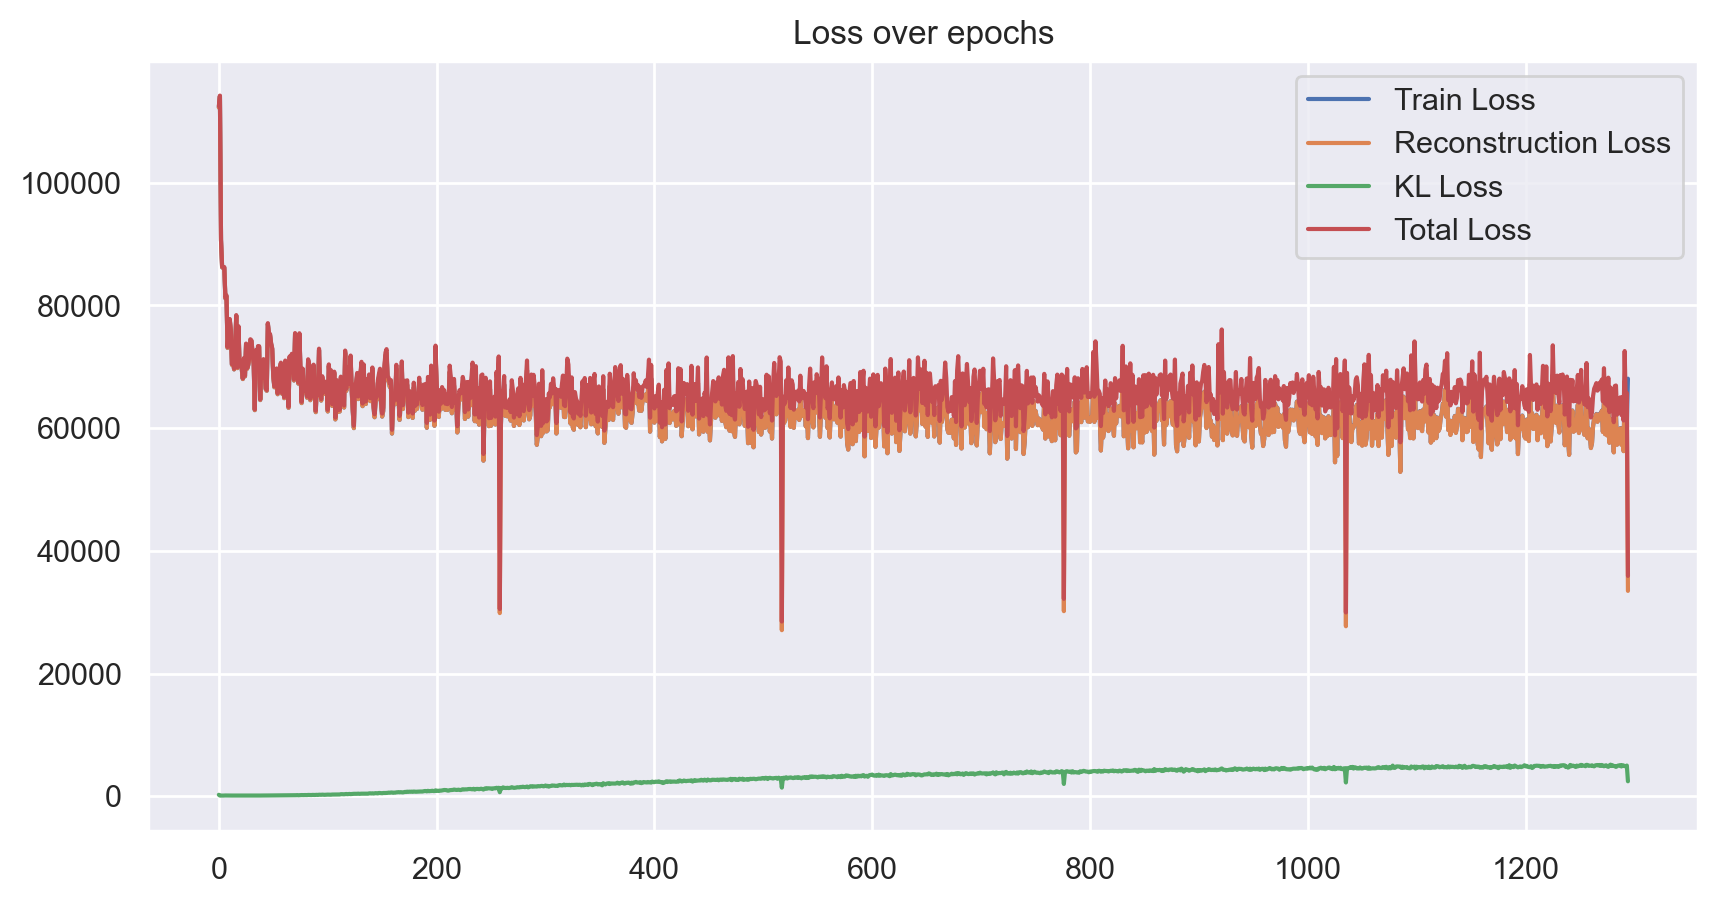

In [16]:
train_loss = np.array(training_plan.train_loss_history)
print("Train loss shape:", train_loss.shape)
train_recon = np.array(training_plan.train_recon_history)
train_kl_local = np.array(training_plan.train_kl_history)
train_loss_sum = train_recon + train_kl_local
train_loss = train_loss*128
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(train_recon, label="Reconstruction Loss")
plt.plot(train_kl_local, label="KL Loss")
plt.plot(train_loss_sum, label="Total Loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [42]:
def run_model(adata, 
              model_class=InformedSCVI,
              activation="relu",
              masks=None,
              likelihood="zinb",
              layer="RNA", 
              key="scVI"):
    
    # Define model
    model_class.setup_anndata(
        adata,
        layer=layer,
        batch_key="sample",
    )
    if masks == None:
        model = model_class(adata, gene_likelihood=likelihood)
    else:
        model = model_class(
            adata,
            gene_likelihood=likelihood,
            activation=activation,
            masks=masks,
        )

    # Train model
    model = model_class(adata)
    training_plan = model.train(max_epochs=5)
    plot_loss(training_plan, save_path=f"../results/figures/{key}/loss.png")

    # Save latent representation
    latent = model.get_latent_representation()
    adata.obsm[f"X_{key}"] = latent
    adata_subset = adata[adata.obs.cell1 == "Tumor"]

    # Save normalized expression
    denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
    denoised = pd.DataFrame(
        denoised,
        index=adata_subset.obs_names,
        columns=adata_subset.var_names,
    )
    os.makedirs(f"../results/models/{key}", exist_ok=True)
    denoised.to_csv(f"../results/models/{key}/denoised_data.csv")

    # Clustering
    sc.pp.neighbors(adata, use_rep=f"X_{key}", key_added=f"neighbors_{key}")
    sc.tl.umap(adata, min_dist=0.3, key_added=f"umap_{key}")
    sc.tl.leiden(adata, key_added=f"leiden_{key}", resolution=0.5)
    sc.settings.figdir = f"../results/figures/{key}/"
    for feature in ["leiden", "cell1", "cell2", "sample"]:
        sc.pl.embedding(adata, basis=f"umap_{key}", color=feature, title=feature, frameon=False, show=False, save=f"_scVI_hvg_{feature}.png")
    
    # Save model
    model.save(f"../results/models/{key}_model", overwrite=True, save_anndata=False)
    
    # Calculate metrics
    elbo = model.get_elbo()
    reconstruction_error = model.get_reconstruction_error()
    silhouette = silhouette_score(latent, adata.obs[f"leiden_{key}"], metric="euclidean")
    ARI = adjusted_rand_score(adata.obs["cell2"], adata.obs[f"leiden_{key}"])
    NMI = normalized_mutual_info_score(adata.obs["cell2"], adata.obs[f"leiden_{key}"])
    homogeneity = homogeneity_score(adata.obs["cell2"], adata.obs[f"leiden_{key}"])
    metrics = pd.DataFrame(
        {
            "elbo": [elbo],
            "reconstruction_error": [reconstruction_error],
            "silhouette": [silhouette],
            "ARI": [ARI],
            "NMI": [NMI],
            "homogeneity": [homogeneity],
        }
    )
    metrics.to_csv(f"../results/models/{key}/metrics.csv", index=False)
    
    return adata

In [43]:
adata


AnnData object with n_obs × n_vars = 36763 × 1839
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden', '_scvi_batch', '_scvi_labels', 'leiden_scVI_hvg'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors_scVI_hvg', 'umap_scVI_hvg', 'leiden_scVI_hvg', 'leiden_colors', 'cell1_colors', 'cell2_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap', 'X_scVI_hvg', 'umap_scVI_hvg'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances', 'neighbors_scVI_hvg_distances', 'neighbors_scVI_hvg_connectivities'

setup_anndata: InformedSCVI


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using masking: none


Training:   0%|          | 0/5 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Train loss shape: (1295,)
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


<Figure size 1000x600 with 0 Axes>

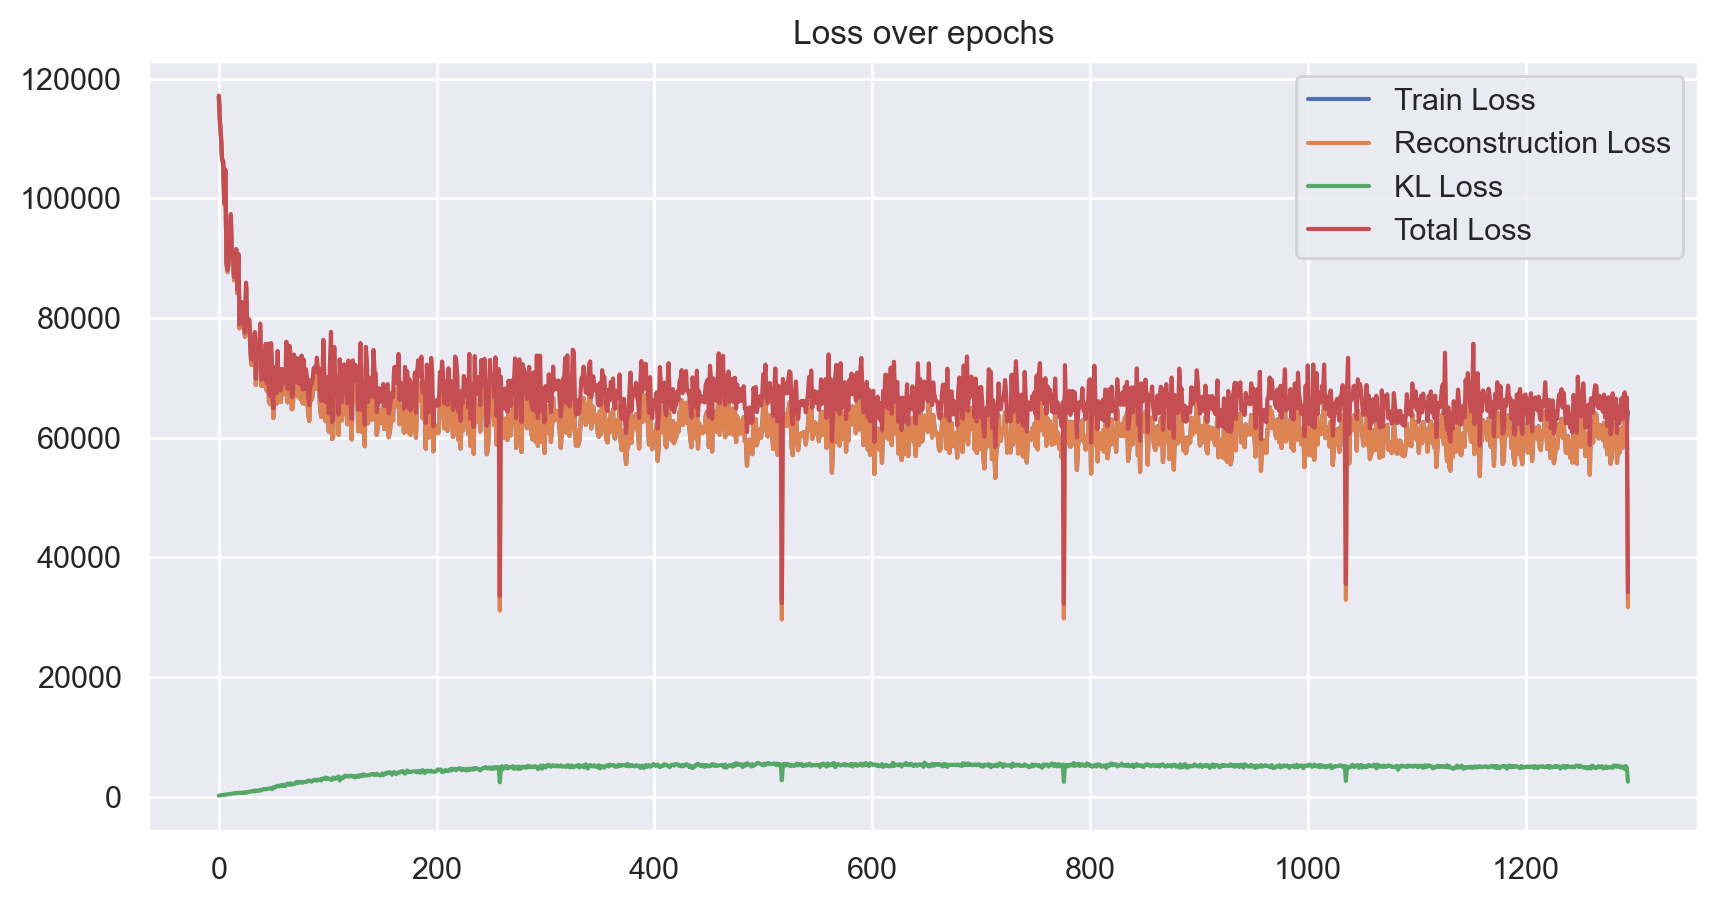

In [46]:
adata = run_model(
    adata,
    model_class=InformedSCVI,
    key="scVI_hvg",
    masks=masks_kegg_NB,
    activation="leaky_relu",
)

In [ ]:
adata_kegg = adata_blank.copy()
adata_kegg = adata_kegg[:, ~adata_kegg.var['ensembl_gene_id'].isna()]

In [72]:
adata_kegg.var

Empty DataFrameView
Columns: [hgnc_symbol, ensembl_gene_id, gene_biotype, n_cells, mean, std]
Index: []

In [69]:
genes_per_pathway, genes_per_circuit, circuits_per_pathway = get_pathway_masks("KEGG_NB")

Current directory: c:\Users\mlsar\Documents\PISCVI\piVAE\notebooks


In [70]:
adata_kegg, genes_per_pathway, genes_per_circuit, circuits_per_pathway = filter_genes(adata_kegg, genes_per_pathway, genes_per_circuit, circuits_per_pathway)


Pathway genes: ['CACNG7', 'NLK', 'PRKACB', 'FGFR3', 'STK3', 'PLA2G4D', 'CRKL', 'EFNA5', 'TGFA', 'TGFB1', 'IL1A', 'FLT3LG', 'TAOK3', 'KIT', 'PPP3R2', 'CACNA2D3', 'GRB2', 'TAOK1', 'ERBB2', 'FLT4', 'TRAF6', 'CACNA1S', 'PLA2G4B', 'EFNA4', 'FGF10', 'NRAS', 'EFNA1', 'FGF17', 'IRAK4', 'STK4', 'MYC', 'IKBKB', 'ARTN', 'DUSP16', 'MAX', 'MAP2K2', 'TAB2', 'ATF4', 'CACNG1', 'MAPKAPK3', 'TNF', 'RAC3', 'MAPKAPK2', 'MKNK1', 'HSPA6', 'MET', 'IGF1', 'CACNA1D', 'NFKB2', 'MAPK8IP2', 'NTF4', 'DUSP3', 'RPS6KA4', 'KDR', 'TEK', 'MAP3K12', 'MAP3K13', 'FGF23', 'MAP3K5', 'EREG', 'RAC2', 'MAP3K11', 'PLA2G4A', 'RAF1', 'MAP3K8', 'SRF', 'PDGFRA', 'MAP4K1', 'FGF1', 'FGF21', 'BDNF', 'MAP4K3', 'PRKCB', 'MAP2K6', 'RPS6KA2', 'CDC42', 'CACNA2D1', 'RAP1B', 'AREG', 'ANGPT4', 'MAP3K3', 'MAPK9', 'IL1RAP', 'RPS6KA5', 'NFATC1', 'IRAK1', 'FGFR4', 'PPM1A', 'RPS6KA6', 'SOS2', 'PLA2G4E', 'ERBB4', 'GDNF', 'NTRK1', 'RASA2', 'CACNA1H', 'GNA12', 'FASLG', 'CASP3', 'ATF2', 'ELK1', 'MAP4K4', 'RASGRF1', 'RASGRP2', 'RASGRP3', 'FGFR1', 'JUND

In [66]:
genes_per_pathway

Empty DataFrame
Columns: []
Index: [hsa04010, hsa04012, hsa04115, hsa04150, hsa04152, hsa04068, hsa04350, hsa04722, hsa05200, hsa04020, hsa04924, hsa04740, hsa04614, hsa04925, hsa04927, hsa04024, hsa04022, hsa04151, hsa04014, hsa04015, hsa04310, hsa04330, hsa04630, hsa04064, hsa04668, hsa04066]

In [58]:

frac = genes_per_circuit.sum(axis=1).mean() / genes_per_circuit.shape[1]
rnd_genes_per_circuit, rnd_genes_per_circuit, rnd_circuits_per_pathway = get_random_masks(adata.var_names, genes_per_circuit.shape[0], genes_per_pathway.shape[0], frac=frac, seed=42)

masks_kegg = [genes_per_circuit, circuits_per_pathway]
masks_kegg_rnd = [rnd_genes_per_circuit, rnd_circuits_per_pathway]

Current directory: c:\Users\mlsar\Documents\PISCVI\piVAE\notebooks


ValueError: p < 0, p > 1 or p is NaN

In [23]:
adata = sc.read("../results/models/informedscvi_model/adata.h5ad")

In [25]:
#adata = adata.copy()

model = InformedSCVI.load("../results/models/piscVI", adata=adata)
model

INFO     File ../results/models/piscVI\model.pt already downloaded                                                 
setup_anndata: InformedSCVI
Finished setup_anndata
Initializing InformedSCVI: InformedSCVI
Using masking SCVI: encoder
Using masking VAE: encoder


SCVI model with the following parameters: 
n_hidden: [634, 26], n_latent: 13, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal, activation: relu, use_masking: encoder.
Training status: Trained
Model's adata is minified?: False

In [27]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

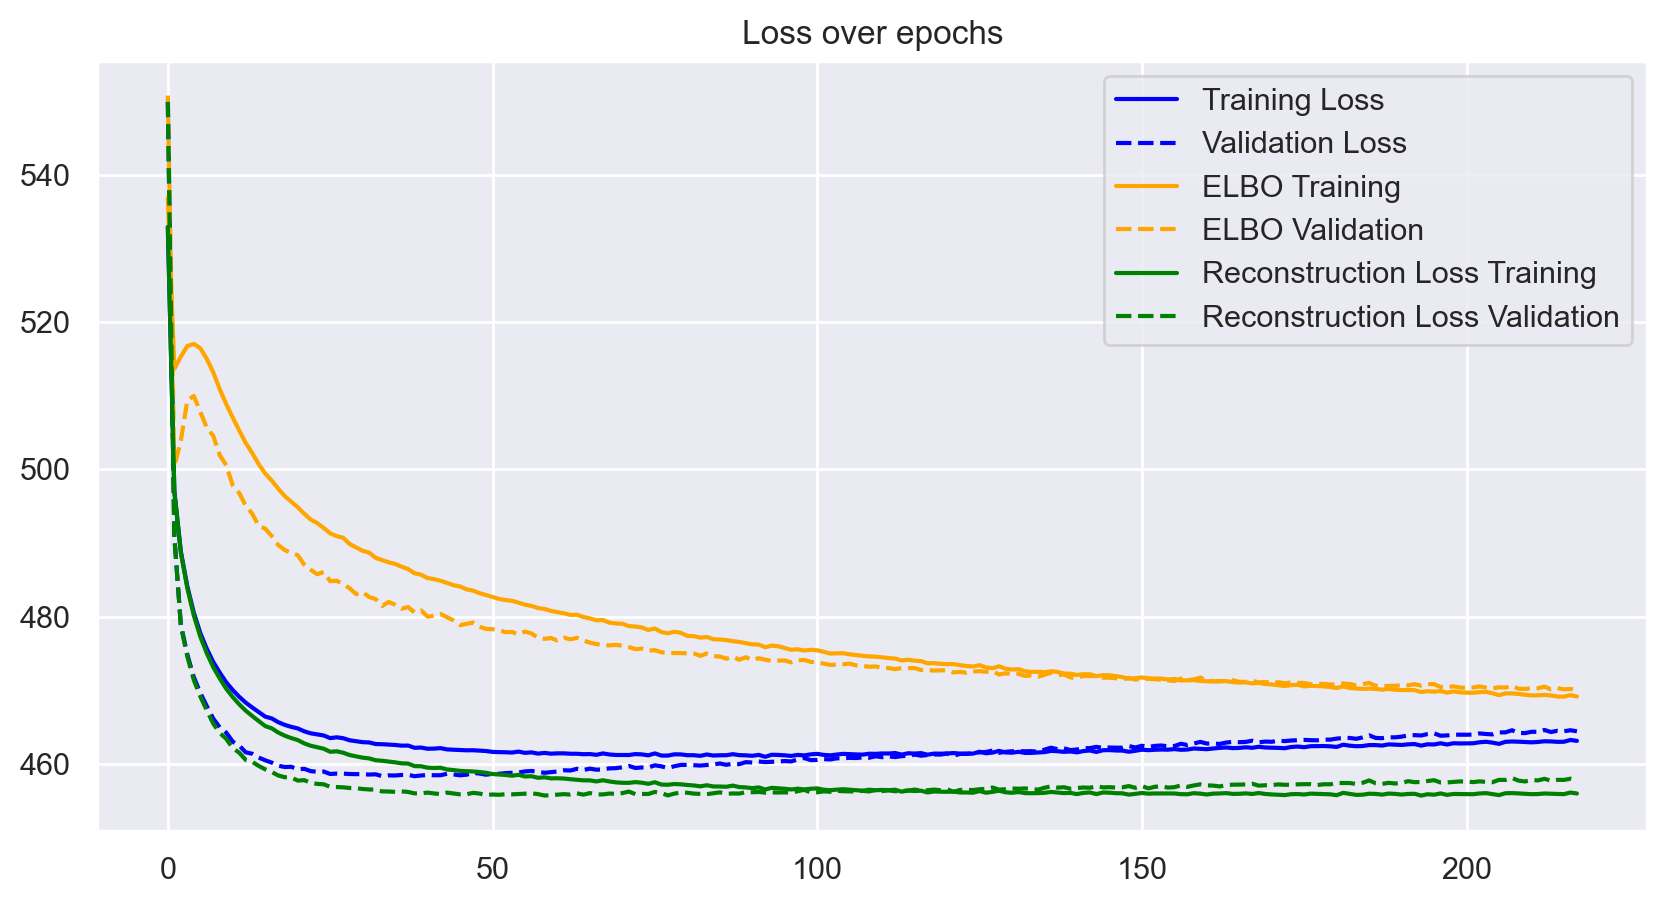

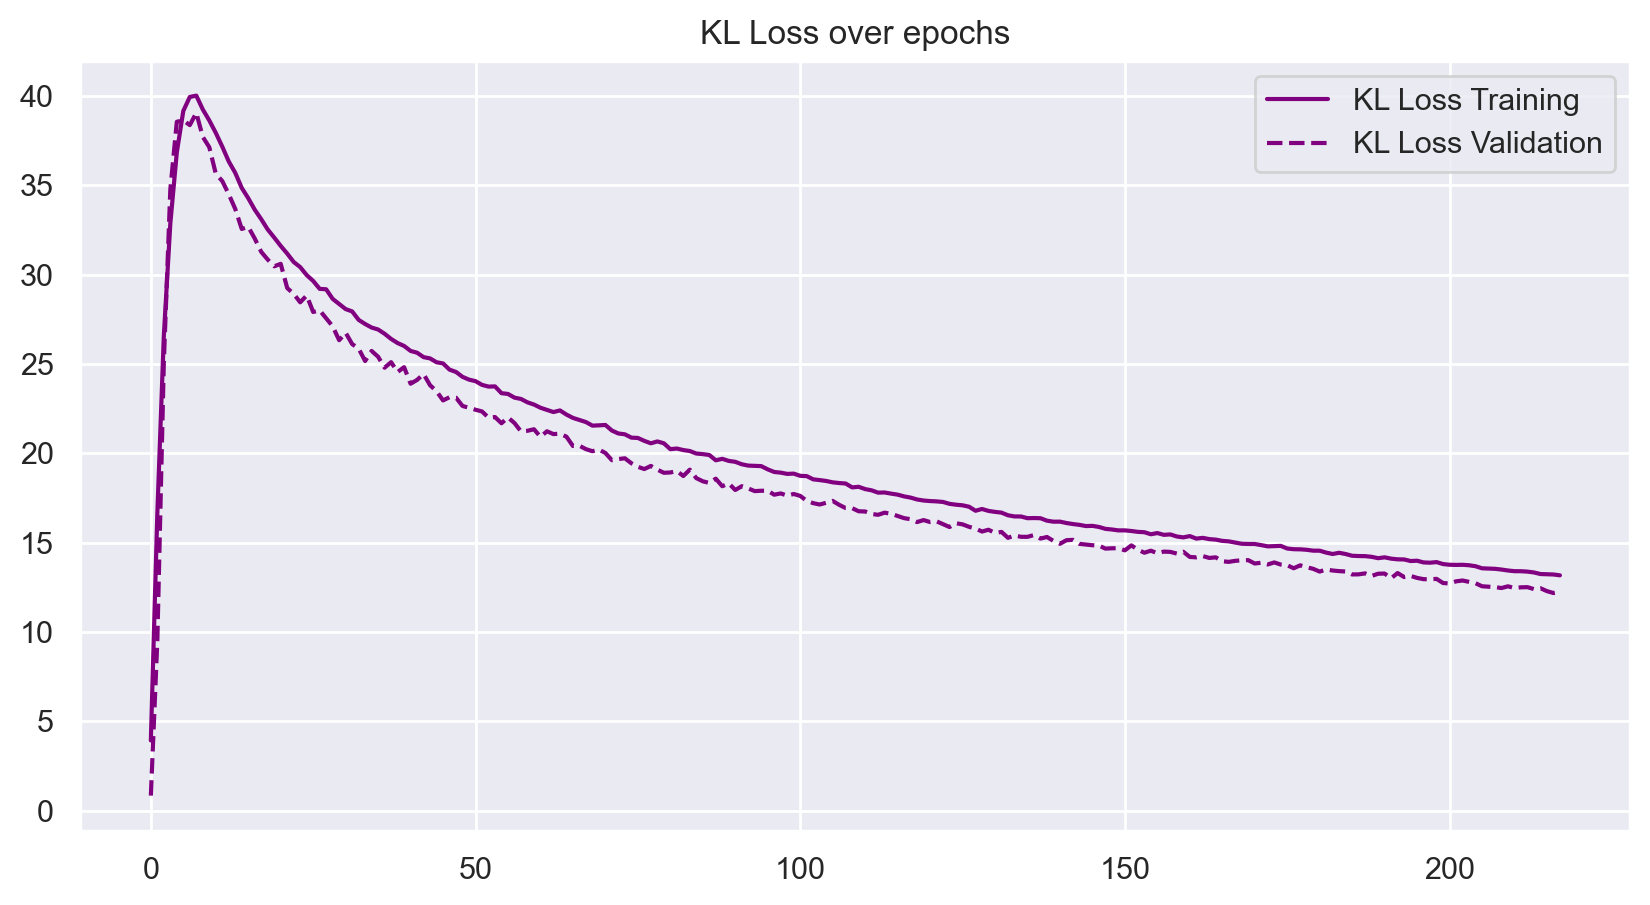

In [36]:
train_loss = np.array(model.history["train_loss_epoch"])
val_loss = np.array(model.history["validation_loss"])
elbo_val = np.array(model.history["elbo_validation"])
recon_val = np.array(model.history["reconstruction_loss_validation"])
kl_local_val = np.array(model.history["kl_local_validation"])
elbo = np.array(model.history["elbo_train"])
recon = np.array(model.history["reconstruction_loss_train"])
kl_local =  np.array(model.history["kl_local_train"])
kl_global = np.array(model.history["kl_global_train"])
sum_loss = kl_local + recon
# train_recon = np.array(training_plan.train_recon_history)
# train_kl_local = np.array(training_plan.train_kl_history)
# train_loss_sum = train_recon + train_kl_local
# train_loss = train_loss*128
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="blue", linestyle="--")
plt.plot(elbo, label="ELBO Training", color="orange")
plt.plot(elbo_val, label="ELBO Validation", color="orange", linestyle="--")
plt.plot(recon, label="Reconstruction Loss Training", color="green")
plt.plot(recon_val, label="Reconstruction Loss Validation", color="green", linestyle="--")
#plt.plot(sum_loss, label="Total Loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(kl_local, label="KL Loss Training", color="purple")
plt.plot(kl_local_val, label="KL Loss Validation", color="purple", linestyle="--")
# plt.plot(train_recon, label="Reconstruction Loss")
# plt.plot(train_kl_local, label="KL Loss")
# plt.plot(train_loss_sum, label="Total Loss")
plt.legend()
plt.title("KL Loss over epochs")
plt.show()

In [53]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent
latent.shape

(36763, 13)

In [54]:
adata_subset = adata[adata.obs.cell1 == "Tumor"]
latent_subset = model.get_latent_representation(adata_subset)
latent_subset.shape

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(1327, 13)

In [55]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

hgnc_symbol                 CACNG7        NLK     PRKACB     FGFR3       STK3
cell_ID                                                                      
NBBM2_ACAACCACAACGAGGT-1  0.033141   6.346867  10.856940  0.186146  22.251120
NBBM2_AGCTCAACAGATCATC-1  0.090745  25.438080   9.028271  0.106458  56.626858
NBBM2_AGCTCAAGTCTCAAGT-1  0.030066  15.982327   7.327054  0.061120  67.284645
NBBM2_CATGCAAAGCTCTGTA-1  0.025787  33.569981  13.189168  0.106931  55.054626
NBBM2_GAGATGGTCCGTGACG-1  0.067959  31.181799   7.716050  0.057722  44.859673

In [121]:
type(denoised)

pandas.core.frame.DataFrame

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI", key_added="neighbors_scVI")
sc.tl.umap(adata, min_dist=0.3, key_added="umap_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)

In [61]:
adata.obs['X_scVI']

cell_ID
NBBM1_AAACGAAGTCCGGCAT-1        0
NBBM1_AAACGCTGTCACAATC-1        1
NBBM1_AAAGGATGTAGGCTGA-1        3
NBBM1_AAAGGTAGTCTCAGGC-1        4
NBBM1_AAAGGTAGTGAGTGAC-1        1
                               ..
NB34_Bone_TTTGTTGAGCGAAACC-1    0
NB34_Bone_TTTGTTGAGTCGCTAT-1    6
NB34_Bone_TTTGTTGAGTCGGCAA-1    0
NB34_Bone_TTTGTTGGTAAGGCTG-1    5
NB34_Bone_TTTGTTGGTGCGTGCT-1    4
Name: X_scVI, Length: 36763, dtype: category
Categories (12, object): ['0', '1', '2', '3', ..., '8', '9', '10', '11']

In [66]:
#VAE metrics
elbo = model.get_elbo()
reconstruction_error = model.get_reconstruction_error()
#Clustering metrics
silhouette = silhouette_score(latent, adata.obs["X_scVI"], metric="euclidean")
ARI = adjusted_rand_score(adata.obs["cell2"], adata.obs["X_scVI"])
NMI = normalized_mutual_info_score(adata.obs["cell2"], adata.obs["X_scVI"])
homogeneity = homogeneity_score(adata.obs["cell2"], adata.obs["X_scVI"])

In [70]:
print(f"ELBO: {elbo}")
print(f"Reconstruction Error: {reconstruction_error['reconstruction_loss']}")
print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index (ARI): {ARI}")
print(f"Normalized Mutual Information Score (NMI): {NMI}")
print(f"Homogeneity Score: {homogeneity}")

ELBO: -462.06866455078125
Reconstruction Error: 450.565673828125
Silhouette Score: 0.1400701403617859
Adjusted Rand Index (ARI): 0.43674167083281684
Normalized Mutual Information Score (NMI): 0.6355744822213416
Homogeneity Score: 0.5630564346039669


In [74]:
bm = Benchmarker(
    adata,
    batch_key="sample",
    label_key="cell2",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=["X_scVI"],
    n_jobs=6,
)
bm.benchmark()

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     30 clusters consist of a single batch or are too small. Skip.                                             


Embeddings: 100%|██████████| 1/1 [02:08<00:00, 128.80s/it]


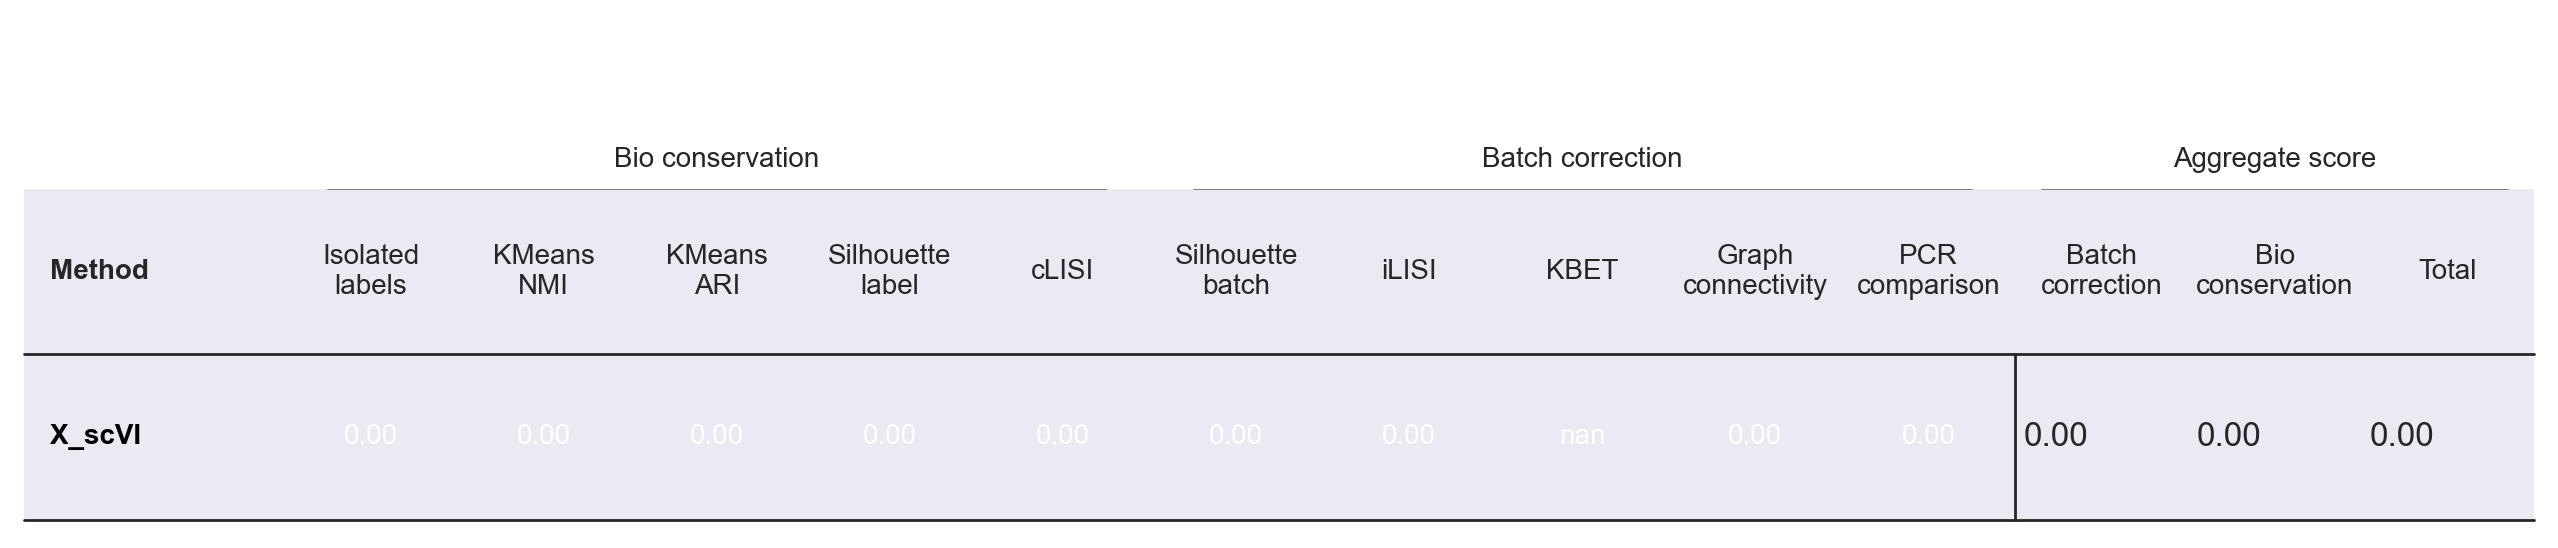

In [75]:
bm.plot_results_table()

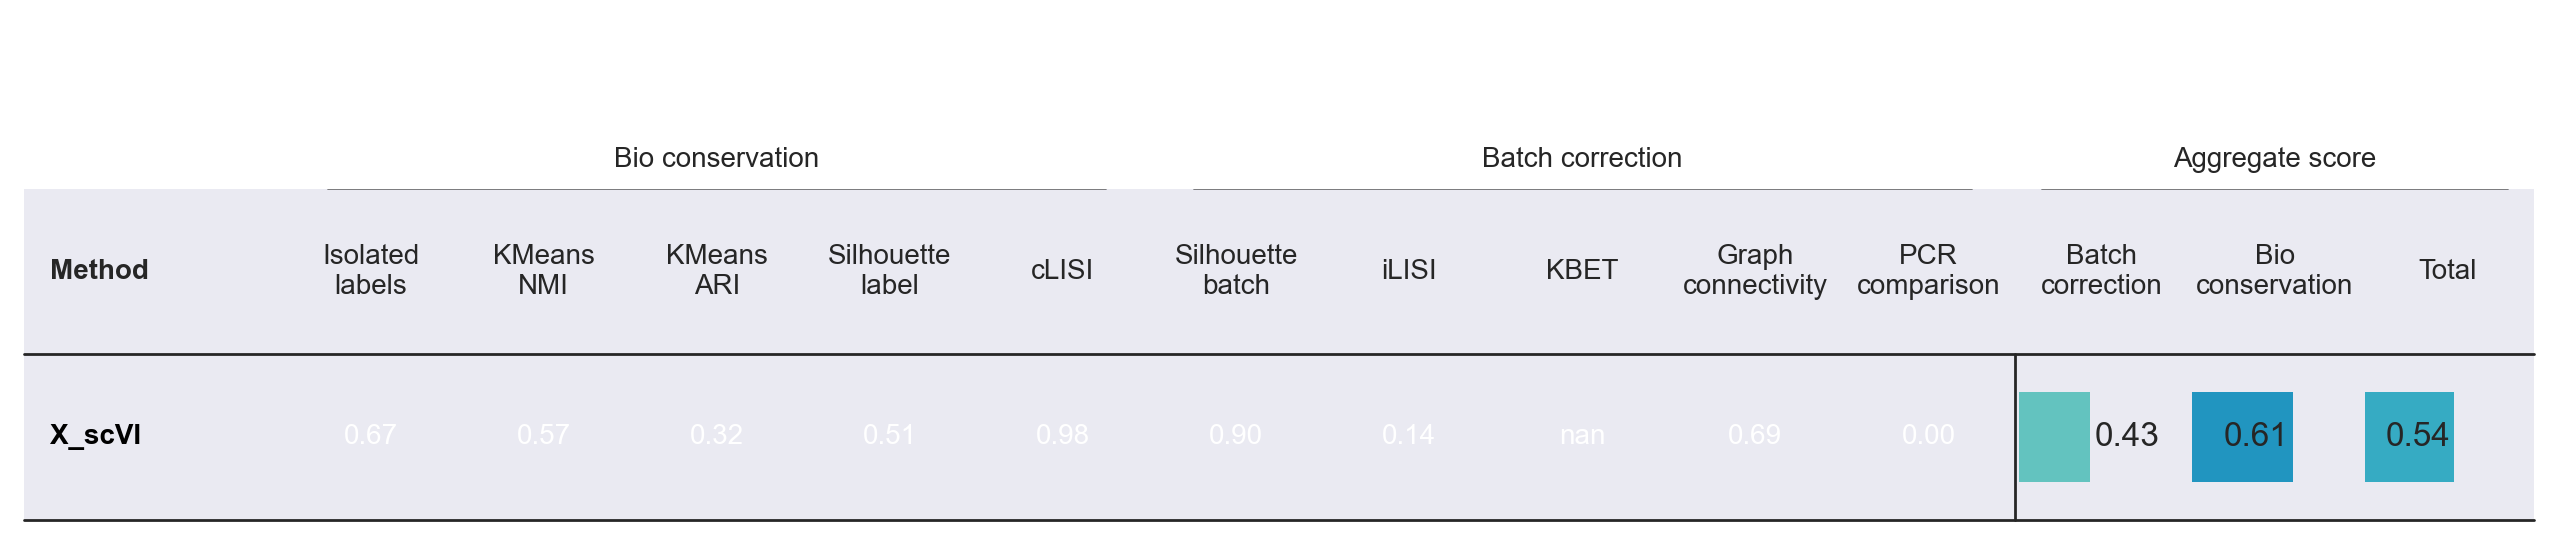

In [76]:
bm.plot_results_table(min_max_scale=False)

In [44]:
adata

AnnData object with n_obs × n_vars = 36763 × 1839
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden', '_scvi_batch', '_scvi_labels', 'X_scVI'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'X_scVI'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [48]:
adata.write("../data/NBsmall/NB.bone.Met_preprocessed_PISCVI.h5ad")

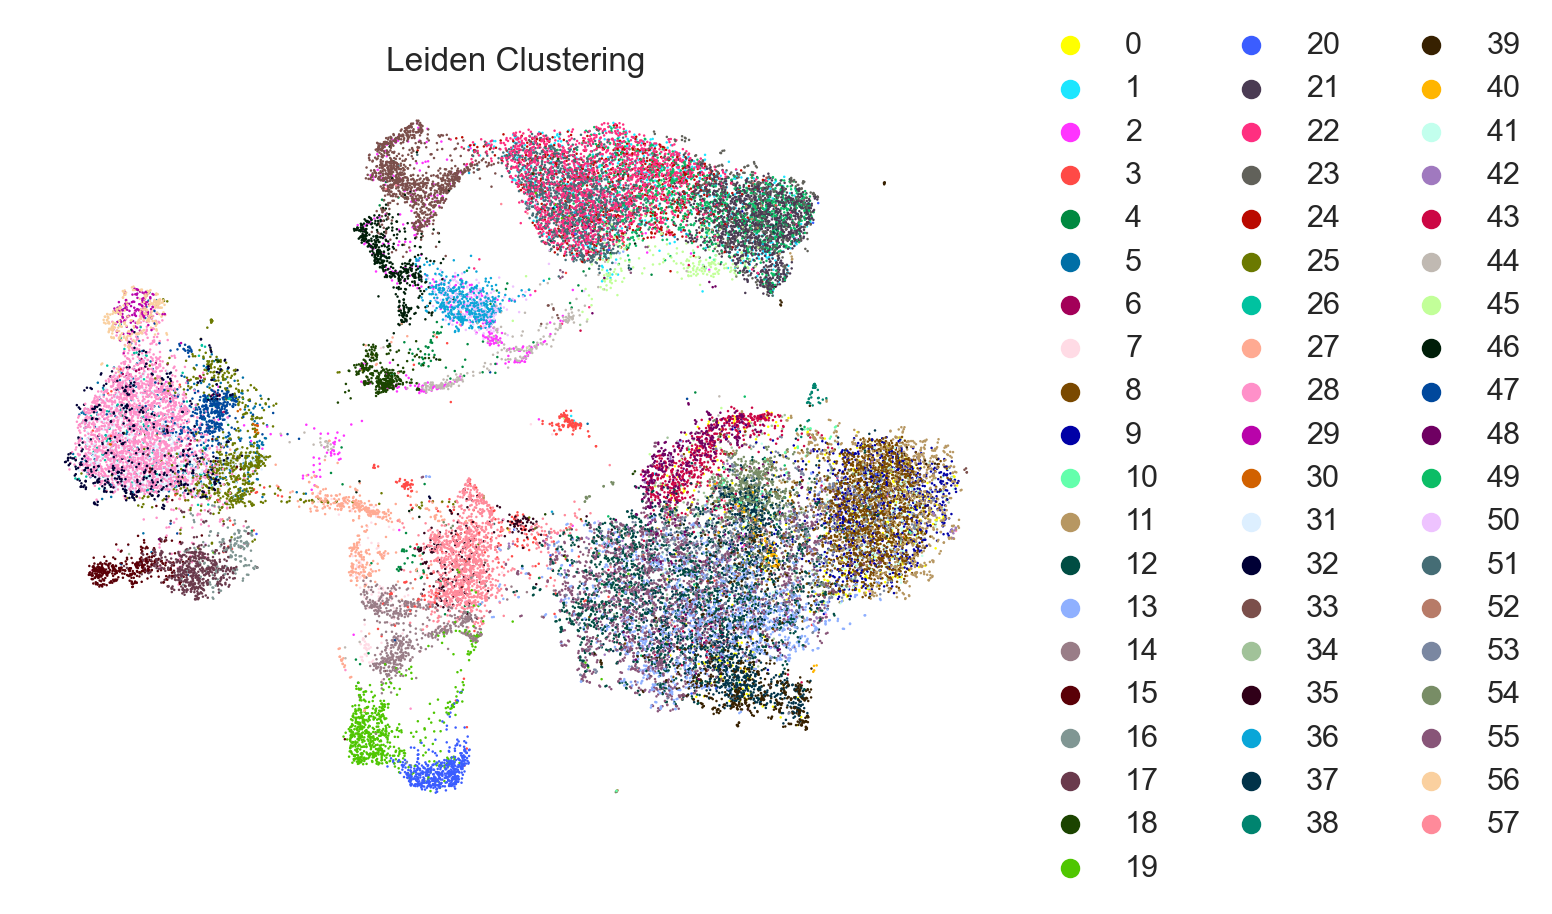

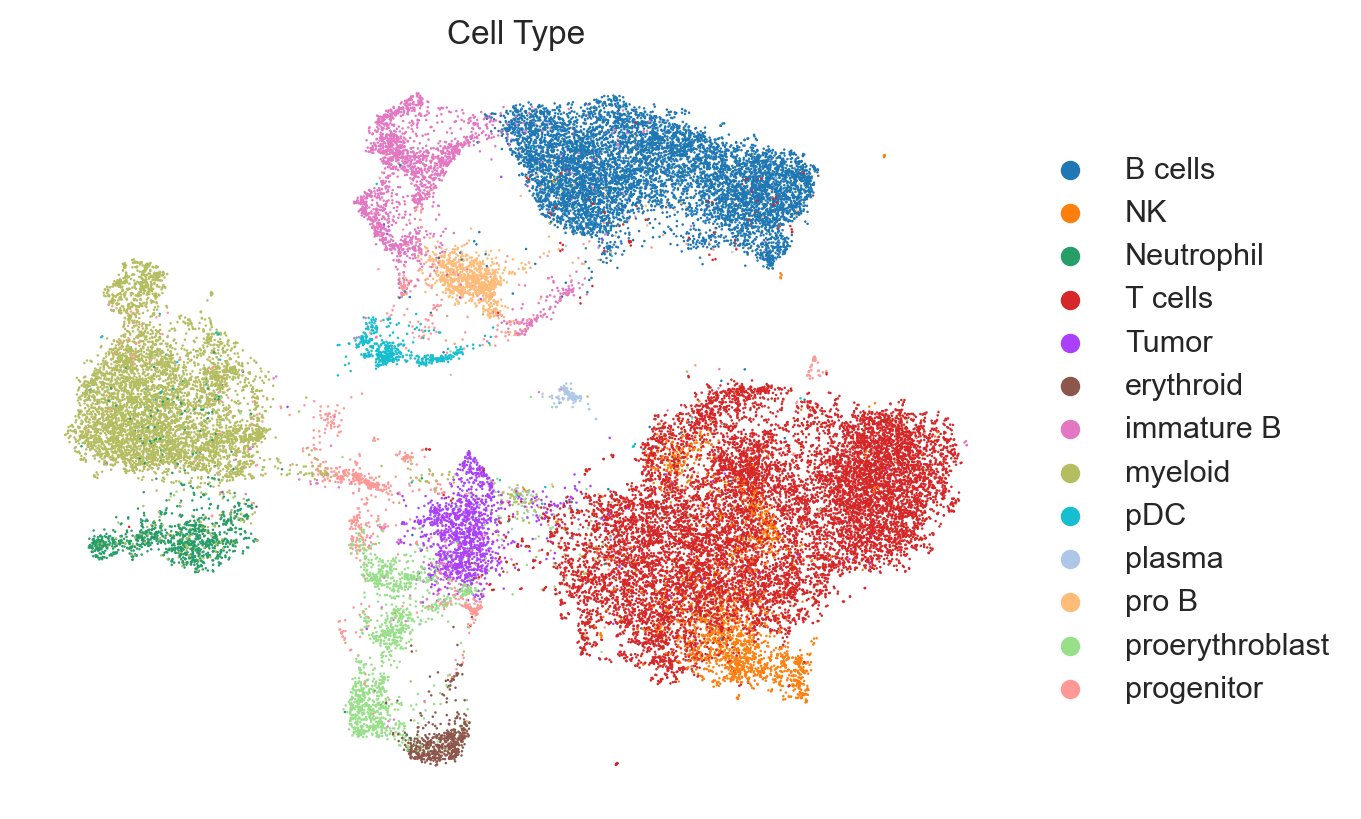

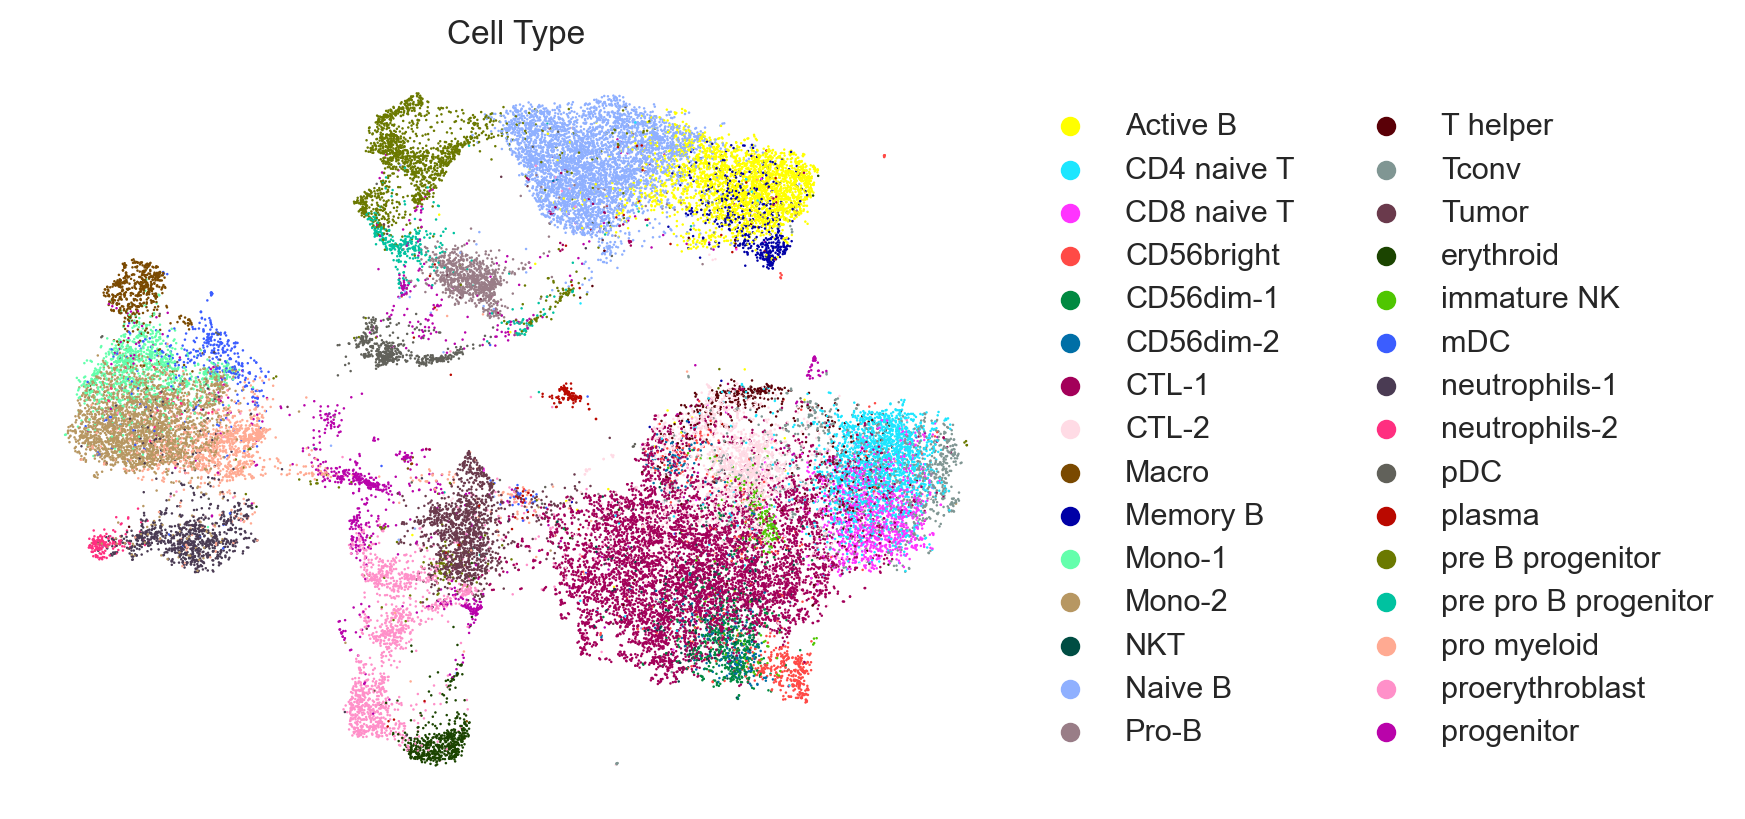

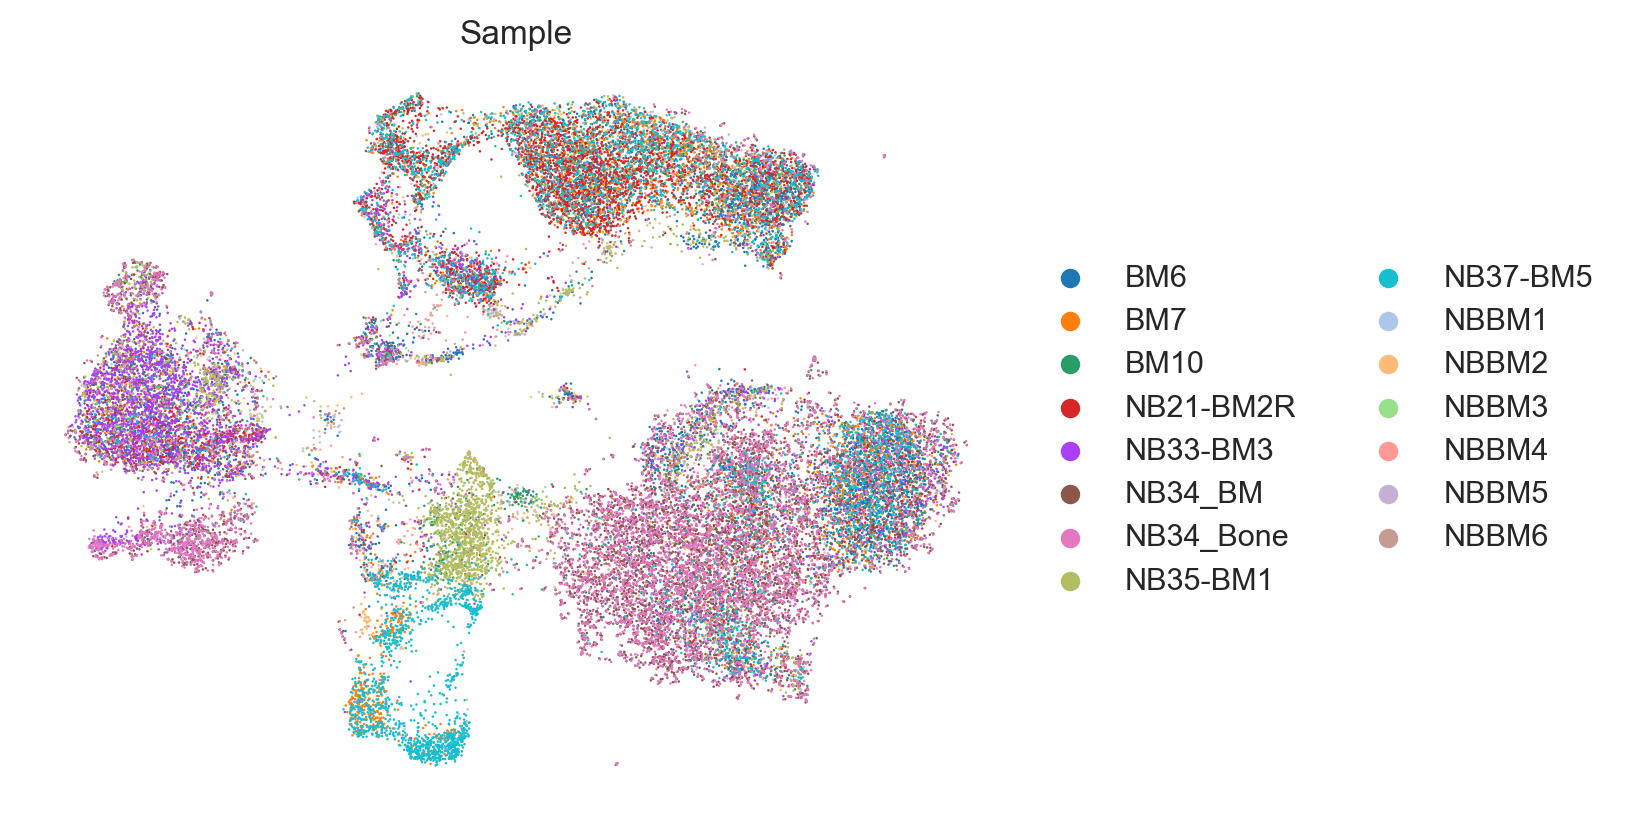

In [47]:
#Plot
sc.pl.umap(
    adata,
    color=["leiden"],
    title="Leiden Clustering",
    frameon=False,
    show=True,
)
sc.pl.umap(
    adata,
    color=["cell1"],
    title="Cell Type",
    frameon=False,
    show=True,
)
sc.pl.umap(
    adata,
    color=["cell2"],
    title="Cell Type",
    frameon=False,
    show=True,
)
sc.pl.umap(
    adata,
    color=["sample"],
    title="Sample",
    frameon=False,
    show=True,
)